<a href="https://colab.research.google.com/github/JUICEMAN123/2048withBOT/blob/main/Music%20Generation%20with%20RNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pretty_midi

     |████████████████████████████████| 5.6 MB 16.1 MB/s 
     |████████████████████████████████| 51 kB 7.4 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591955 sha256=90b8c04c274243b477ed3ea4eb792e89d5824a91aa6b655e6f5df432bf3e040c
  Stored in directory: /root/.cache/pip/wheels/ad/74/7c/a06473ca8dcb63efb98c1e67667ce39d52100f837835ea18fa
Successfully built pretty-midi


In [3]:
import os
import numpy as np
import json
import tensorflow as tf
from tensorflow.keras import layers, regularizers, models
import pretty_midi
from PIL import Image
import matplotlib.pyplot as plt

import time
import logging
import pathlib
from tqdm.autonotebook import tqdm
import pandas as pd

import random

from IPython import display

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  del sys.path[0]


In [4]:
tf.version.VERSION

'2.7.0'

In [5]:
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings

In [6]:
path = '/content/drive/MyDrive/maestro-v3.0.0-midi/maestro-v3.0.0/2018'

os.chdir(path)
midi_paths = []
for fn in os.listdir():
  midi_paths.append(path+'/'+fn)

os.chdir('/content')

In [7]:
new_dir = '/content/drive/MyDrive/maestro_midi_images/'

In [8]:
FS = 10
midi_dims = 127
seq_len = 250

In [9]:
def midi2proll(filename):
  midi_pretty_format = pretty_midi.PrettyMIDI(filename)
  midi_piano = midi_pretty_format.instruments[0]
  midi_piano_roll = midi_piano.get_piano_roll(fs=FS)
  return midi_piano_roll # returns piano roll in format (128 notes, time)

def proll2midi(proll):
  notes, frames = proll.shape
  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(program=0)

  proll = np.pad(proll, [(0, 0), (1, 1)], 'constant')
  velocity_changes = np.nonzero(np.diff(proll).T)

  prev_velocities = np.zeros(notes, dtype=int)
  note_on_time = np.zeros(notes)

  for time, note in zip(*velocity_changes):
      velocity = proll[note, time + 1]
      time = time / FS
      if velocity > 0:
          if prev_velocities[note] == 0:
              note_on_time[note] = time
              prev_velocities[note] = velocity
      else:
          pm_note = pretty_midi.Note(
              velocity=prev_velocities[note],
              pitch=note,
              start=note_on_time[note],
              end=time)
          instrument.notes.append(pm_note)
          prev_velocities[note] = 0
  pm.instruments.append(instrument)
  return pm

def proll2img(proll, show=False):
  im = Image.fromarray(np.uint8(proll))
  if show:
    plt.imshow(np.asarray(im), aspect='auto', cmap='gray')
  return im

def proll2notelist(proll):
  pnotelist = []
  for t, tarr in enumerate(np.transpose(proll)):
    pnotelist.append([])
    for n, val in enumerate(tarr):
      if(val > 0):
        pnotelist[t].append(str(n))          
  return pnotelist

def pnotelist2proll(pnotelist):
  proll = np.zeros((midi_dims, len(pnotelist)))
  for t, notes in enumerate(pnotelist):
    for n in notes:
      proll[n][t] = 1
  return proll

In [10]:
def transform_pnotelist(pnotelist):
  transformed_pnotelist = []
  for notes in pnotelist:
    transformed_pnotelist.append(','.join(notes))
  return np.asarray(transformed_pnotelist)

def untransform_pnotelist(pnotelist):
  untransformed_pnotelist = []
  for t in pnotelist:
    notes = t.split(',')
    notes = [int(n) for n in notes]
    untransformed_pnotelist.append(notes)
  return untransformed_pnotelist

def chop(arr, chop_size):
  chops = np.asarray(np.arange(chop_size, len(arr), chop_size))
  chunks = np.split(arr, chops, axis=0)
  return chunks[:-1]

def get_all_sequences(filepaths, chop_size=seq_len+1):
  all_seq = []
  for i, fp in tqdm(enumerate(filepaths), total=len(filepaths)):
    chunks = chop(transform_pnotelist(proll2notelist(midi2proll(fp))), chop_size)
    all_seq.extend(chunks)
  all_seq = np.asarray(all_seq)
  return all_seq

def pad_array(arr, target_length):
  if target_length < np.shape(arr)[0]:
    return arr[:target_length]
  padding = np.full((target_length - np.shape(arr)[0],), '')
  return np.concatenate([arr, padding])

In [11]:
all_seq = get_all_sequences(midi_paths[:32])
musical_corpus = np.concatenate(all_seq)

  0%|          | 0/32 [00:00<?, ?it/s]

In [12]:
print(np.shape(all_seq))
all_seq

(1182, 251)


array([['', '', '', ..., '45,57,69,73,76', '45,57,69,73,76',
        '45,57,69,73,76'],
       ['45,57,69,73,76', '45,57,69,73,76', '45,57,69,73,76', ...,
        '62,69,77', '62,69,78', '62,66,77'],
       ['62,66,78', '62,69,77', '62,69,78', ..., '62,66,79', '62',
        '62,69'],
       ...,
       ['', '48', '48', ..., '55,58,65,82,94', '', ''],
       ['75', '', '', ..., '', '68,77', '68,73,77,80'],
       ['49,68,73,77,80', '49,68,73,77,80', '49,68,73,77,80', ...,
        '51,59,60,62,63,77,80,89,92', '51,59,60,62,63,77,80,89,92',
        '51,59,60,62,63,77,80,89,92']], dtype='<U128')

In [13]:
FINAL_VOCAB_SIZE = 50000

vocab_size = np.shape(np.unique(musical_corpus))[0]
print('Base Vocab Size', vocab_size)

vec = layers.TextVectorization(max_tokens=FINAL_VOCAB_SIZE + 1, standardize=None, split=None)
vec.adapt(musical_corpus)
vocabulary = vec.get_vocabulary()
vocabulary.remove('[UNK]')

print('Final Vocab Size', len(vocabulary))

Base Vocab Size 56107
Final Vocab Size 50000


In [14]:
ids_from_chars = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=vocabulary, mask_token=None)
chars_from_ids = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [15]:
all_seq_vectorized = ids_from_chars(all_seq)

In [16]:
all_seq_vectorized

<tf.Tensor: shape=(1182, 251), dtype=int64, numpy=
array([[    1,     1,     1, ...,  4141,  4141,  4141],
       [ 4141,  4141,  4141, ...,   928,   167,  3177],
       [  338,   928,   167, ...,  2655,     4,   182],
       ...,
       [    1,    35,    35, ..., 38831,     1,     1],
       [   15,     1,     1, ...,     1,  1908, 16624],
       [10899, 10899, 10899, ..., 18572, 18572, 18572]])>

In [17]:
def data_target_split(all_seq):
  return all_seq[:, :-1], all_seq[:, 1:]

In [18]:
train_data, train_target = data_target_split(all_seq_vectorized)

In [19]:
TOTAL_SIZE = np.shape(train_data)[0]
BATCH_SIZE = 32
N_TRAIN_BATCHES = int(TOTAL_SIZE/BATCH_SIZE)
N_TEST_BATCHES = N_TRAIN_BATCHES

In [20]:
train_dataset = (
    tf.data.Dataset.from_tensor_slices((train_data, train_target))
    .cache()
    .shuffle(10000)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

test_dataset = train_dataset

In [21]:
train_dataset

<PrefetchDataset shapes: ((32, 250), (32, 250)), types: (tf.int64, tf.int64)>

# Model

In [22]:
vocab_size = len(ids_from_chars.get_vocabulary())
embedding_dim = 128
rnn_units = 384
dropout_prop = 0.4
input_shape = (BATCH_SIZE, seq_len)

In [23]:
class BasicStoryGenerator(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units, dropout_prop):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru1 = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True,
                                   dropout=dropout_prop)
    self.gru2 = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True,
                                   dropout=dropout_prop)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states1=None, states2=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states1 is None:
      states1 = self.gru1.get_initial_state(x)
    x, states1 = self.gru1(x, initial_state=states1, training=training)
    if states2 is None:
      states2 = self.gru2.get_initial_state(x)
    x, states2 = self.gru2(x, initial_state=states2, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states1, states2
    else:
      return x

In [24]:
model = BasicStoryGenerator(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    dropout_prop=dropout_prop)

In [25]:
model.build(input_shape=input_shape)
model.summary()

Model: "basic_story_generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  6400128   
                                                                 
 gru (GRU)                   multiple                  592128    
                                                                 
 gru_1 (GRU)                 multiple                  887040    
                                                                 
 dense (Dense)               multiple                  19250385  
                                                                 
Total params: 27,129,681
Trainable params: 27,129,681
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True))

# Train Model

**Setup Checkpoints**

In [27]:
!pwd

/content


In [28]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True,
    save_freq=N_TRAIN_BATCHES*5)

**Fit Model**

Might need to reduce vocabulary size as the number of parameters is enormous.

In [60]:
EPOCHS = 25

In [61]:
history = model.fit(train_dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/25
36/36 [==============================] - 14s 401ms/step - loss: 4.5694
Epoch 2/25
36/36 [==============================] - 15s 408ms/step - loss: 4.3945
Epoch 3/25
36/36 [==============================] - 15s 410ms/step - loss: 4.2382
Epoch 4/25
36/36 [==============================] - 16s 441ms/step - loss: 4.0648
Epoch 5/25
36/36 [==============================] - 15s 422ms/step - loss: 3.8840
Epoch 6/25
36/36 [==============================] - 15s 427ms/step - loss: 3.7213
Epoch 7/25
36/36 [==============================] - 15s 431ms/step - loss: 3.5698
Epoch 8/25
36/36 [==============================] - 16s 431ms/step - loss: 3.4247
Epoch 9/25
36/36 [==============================] - 17s 462ms/step - loss: 3.2976
Epoch 10/25
36/36 [==============================] - 16s 440ms/step - loss: 3.1837
Epoch 11/25
36/36 [==============================] - 16s 437ms/step - loss: 3.0595
Epoch 12/25
36/36 [==============================] - 16s 437ms/step - loss: 2.9688
Epoch 13/25
3

# Generate Text

**Parameters**

In [62]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]', ''])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states1=None, states2=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states1, states2 = self.model(inputs=input_ids, states1=states1, states2=states2, return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states1, states2

In [66]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars, temperature=0.7)

In [67]:
start = time.time()
states1, states2 = None, None
start_char = chars_from_ids(random.randrange(1, 100)).numpy().decode('utf-8')
next_char = tf.constant([start_char])
result = [tf.squeeze(next_char).numpy()]

for n in range(250):
  next_char, states1, states2 = one_step_model.generate_one_step(next_char, states1=states1, states2=states2)
  result.append(tf.squeeze(next_char).numpy())


result = np.array([t.decode('utf-8') for t in result])
end = time.time()
# print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)


Run time: 4.877634525299072


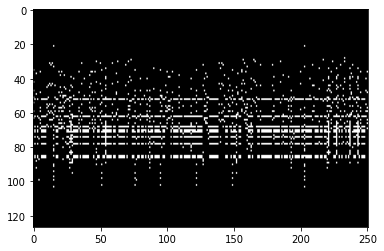

In [68]:
proll = pnotelist2proll(untransform_pnotelist(result)) * 64
img = proll2img(proll, show=True)

In [69]:
target_dir = '/content/drive/MyDrive/rnn-music-midis/'

In [70]:
proll2midi(proll).write(target_dir + str(len(os.listdir(target_dir))) + '.mid')

In [ ]:
# model.save_weights('/content/drive/MyDrive/rnn-music-midis/models')